In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
# load a  colormap from https://www.fabiocrameri.ch/colourmaps/
%run cmap.py
romaO
tokyo

# Introduction
This notebook is the analysis of GTSM nodal tide reanalysis run. In this run we simulate 19 years of just tidal forcing. The main research question is how does the nodal tide, the 18.613 cycle, affect the mean sea level and the tidal range. This question is relevant to be able to accurately assess the local sea-level rise. It can also help to predict so called king tides. The nodal tide is also known to affect cycles in vegetation and morphology in areas with higher tidal amplitude and shallow shores.  

We use the following model run.
- Schematization: GTSMv3.0EMODnet
- Bathymetry: EMODnet2020
- Run: production_runs_2021 (No Wind, No Waves, All tidal constituents active)
- Runtime 1999-2017


In [56]:
# All results (postprocessed using CDO for annual mean/min/max are stored here)
data_dir = '/Users/baart_f/data/gtsm/nodal'
ds_mean = xr.open_mfdataset(data_dir + '/EM_*_YEARMEAN_his.nc', combine='by_coords')
ds_max = xr.open_mfdataset(data_dir + '/EM_*_YEARMAX_his.nc', combine='by_coords')
ds_min = xr.open_mfdataset(data_dir + '/EM_*_YEARMIN_his.nc', combine='by_coords')

In [ ]:
#retrieve station names from hisfile (they were lost with cdo commands for subset netcdf files)
try:
    from dfm_tools.get_nc_helpers import get_hisstationlist
    file_his = data_dir + '/EM_19990101_0000_short_his.nc'
    #file_his = r'p:\\1230882-emodnet_hrsm\\GTSMv3.0EMODnet\\EMODnet2020\\production_runs_2021\\EM_19990101\\EM_19990101_0000_his.nc'
    stations_pd = get_hisstationlist(file_nc=file_his,varname='waterlevel')
except:
    print('if you want station names in the dataframes, install dfm_tools in your environment (pip install git+https://github.com/openearth/dfm_tools)')


# Checks

In [4]:
dates  = ds_mean.waterlevel.time.values.astype('M8[ms]').astype('O')
# we'll just use the years
# This assumes that annual waterlevels are used that are stored left-padded, the mean waterlevel for 2020 is stored as 2020-1-1
# This is not logical, but common practice.
year = np.array([x.year for x in dates], dtype='double')

assert  np.allclose(np.diff(year), 1), f'all years should be sequential: {year}'
# show all the years
year


array([1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017.])

In [5]:
lon = ds_mean.waterlevel.station_x_coordinate.values
lat = ds_mean.waterlevel.station_y_coordinate.values

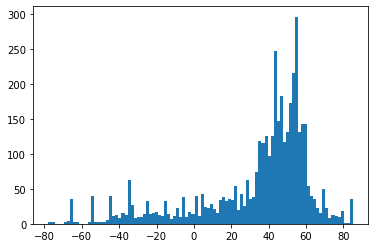

In [18]:
# Using the PSMSL and EU stations gives a skewness towards higher latitudes 
# (normalize in results)
plt.hist(lat, bins=100);

# Mean sea level analysis
We will first analyse mean sea level. For this we will use a simple [harmonic fit](https://www.researchgate.net/profile/Phajm-Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) where we include two linearized components for the nodal tide and a constant sea-level. Using this harmonic fit we estimate the phase, amplitude and mean sea level using an ordinary least squared regression fit. From this fit, we can compute the phase and amplitude per station. 



In [19]:
"""define a simple linear model, with nodal tide and without wind """
X = np.c_[
    np.cos(2*np.pi*(year - 1970)/18.613),
    np.sin(2*np.pi*(year - 1970)/18.613)
]

X = sm.add_constant(X)
Y = ds_mean.waterlevel.values
names = ['Constant', 'Nodal U', 'Nodal V']
model = sm.OLS(Y, X, missing='drop')
fit = model.fit()
Constant = fit.params[0]
A = fit.params[1]
B = fit.params[2]
phase = np.arctan2(B, A)
amplitude = np.sqrt(A**2 + B**2)


# Check mean sea level
First we check if the mean water level is approximately 0. Possible cause for deviation is that we are using a non-uniform gravity map. 

Then we check if the constant water level is almost equal to the mean water level. If that's the case this histogram should be centered around 0. If this is not the case, we might want to examine a few of the extremes. Other causes for deviations include using a slightly longer time window (we now have exactly one cycle).

,lat,lon,mean_waterlevel,amplitude
2823,46.860351,-71.088867,3.387255,0.008704
603,16.479492,97.602539,1.512246,0.030938
3435,61.245114,-149.912109,1.380460,0.033137
3032,59.326171,-135.366211,1.163982,0.033994
3941,36.958007,126.811523,0.715108,0.024142
1068,49.445801,0.314941,0.700016,0.023753
4157,51.569824,-2.702637,0.556875,0.018744
1130,51.511230,-2.717285,0.545699,0.018408
1204,51.496582,-2.731934,0.535976,0.018089
1326,53.327636,7.243652,0.459714,0.002676


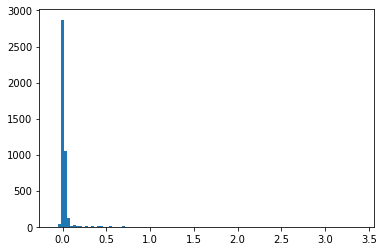

In [25]:

# Check exeptional waterlevels
mean_waterlevel = np.nanmean(ds_mean.waterlevel.values, axis=0)
plt.hist(mean_waterlevel, bins=100);
df = pd.DataFrame(data=dict(lat=lat, lon=lon, mean_waterlevel=mean_waterlevel, amplitude=amplitude))
df = df.drop_duplicates(['lat', 'lon'])

# top 10 highest mean water levels
df.sort_values('mean_waterlevel', ascending=False).head(n=10)

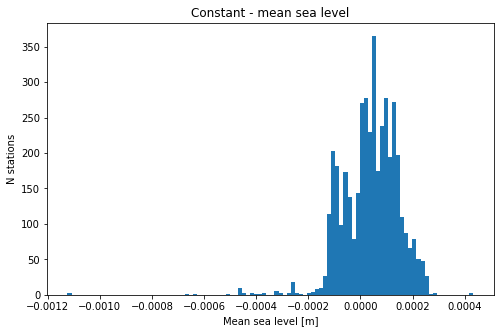

In [26]:
# we don't want the fit of the nodal cycle to result in a different mean, check this.
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(Constant - mean_waterlevel, bins=100);
ax.set_title('Constant - mean sea level')
ax.set_xlabel('Mean sea level [m]')
ax.set_ylabel('N stations');

# Mean sea level map
This map is the mean sea level, taking into account the nodal tide. This map probably correlates to a map of gravity/mass that we used as input. There are a few outliers that have a much higher than average water level.
Also check if the timespan (18 years is causing this). 

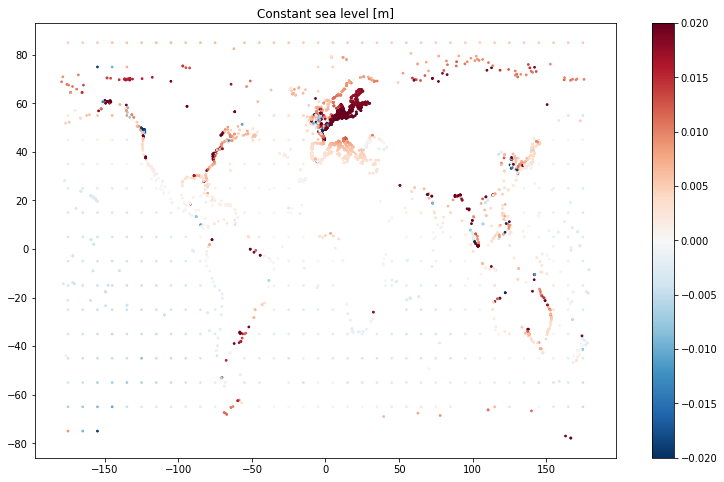

In [27]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Constant sea level [m]')
sc = ax.scatter(lon, lat, c=Constant, s=3, vmax=0.02, vmin=-0.02, cmap='RdBu_r', label='Mean sea level [m]')
plt.colorbar(sc, ax=ax, )

# Nodal phase map
This map is the nodal cycle phase. This map probably shows a strong correlation with the [equilibrium](https://www.researchgate.net/profile/Phajm_Gelder/publication/236019217_The_Effect_of_the_186-Year_Lunar_Nodal_Cycle_on_Regional_Sea-Level_Rise_Estimates/links/0deec533fc3c070917000000/The-Effect-of-the-186-Year-Lunar-Nodal-Cycle-on-Regional-Sea-Level-Rise-Estimates.pdf) (figure 4c) tide. Points are scaled with their amplitude so you don't see colors for points without nodal tide, where the phase is random. 

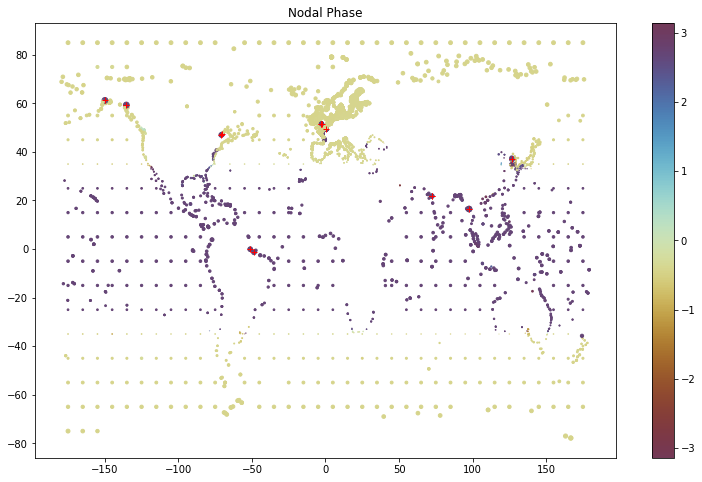

In [51]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Phase')
sc = ax.scatter(lon, lat,  c=phase, cmap=romaO, vmin=-np.pi, vmax=np.pi, s=amplitude * 1000)
plt.colorbar(sc, ax=ax)

# show extreme locations that deviate from equilibrium and need to be investigated
top_n = df.sort_values('amplitude', ascending=False).query('amplitude > 0.018')
ax.plot(top_n['lon'], top_n['lat'], 'r+')


# Nodal amplitude map
This map is the nodal cycle amplitude. You expect to see higher amplitude at the equator and higher towards the higher latitudes.



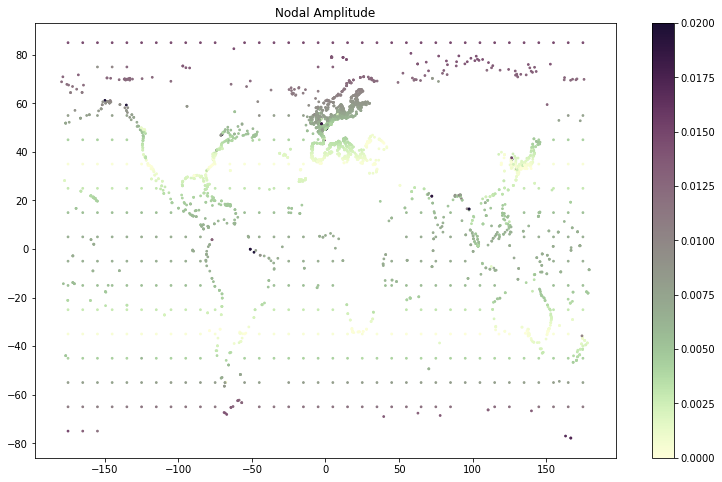

In [52]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Amplitude')
im = ax.scatter(lon, lat,  c=amplitude, cmap=tokyo_r, vmin=0, vmax=0.02, s=3, label='amplitude')
plt.colorbar(im, ax=ax)


# Amplitude and phase as a function of latitude
The figures below show the amplitude and phase as a function of latitude. This should be a squared sine function (or something like that) and a dichotomous phase plot, where the equator is in opposite phase.  We see a few points on the east US coast (Chessapeake Bay) that are in the opposite phase from equilibrium. 

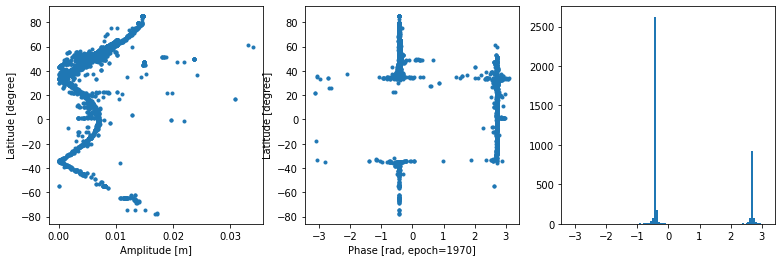

In [53]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4))
axes[0].plot(amplitude, lat, '.');
axes[0].set_xlabel('Amplitude [m]')
axes[0].set_ylabel('Latitude [degree]')
axes[1].plot(phase, lat, '.');
axes[1].set_xlabel('Phase [rad, epoch=1970]')
axes[1].set_ylabel('Latitude [degree]')
axes[2].hist(phase, bins=100);


In [54]:
df = pd.DataFrame(data=dict(lat=lat, lon=lon, amplitude=amplitude))
df.sort_values('amplitude', ascending=False).head(n=10)

,lat,lon,amplitude
3032,59.326171,-135.366211,0.033994
3435,61.245114,-149.912109,0.033137
3222,16.479492,97.602539,0.030938
603,16.479492,97.602539,0.030938
3941,36.958007,126.811523,0.024142
1976,49.445801,0.314941,0.023753
1989,49.445801,0.314941,0.023753
1987,49.445801,0.314941,0.023753
1068,49.445801,0.314941,0.023753
1988,49.445801,0.314941,0.023753


# Timeseries
Here we visualize all timeseries by computing anomalies per station and sorting them by their latitude. You see the opposite phases around the 40 latitude. 

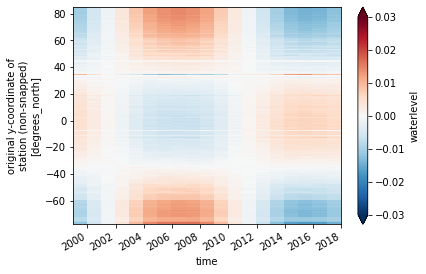

In [15]:
anomaly = (ds_mean.waterlevel - ds_mean.waterlevel.mean(axis=0))
idx = np.argsort(ds_mean.station_y_coordinate.values)
anomaly[:, idx].plot(y='station_y_coordinate', x='time', vmin=-0.03, vmax=0.03, cmap='RdBu_r')
# ds_mean.time[7]


# TODO: Nodal Ampltitude 
Describe spatial pattern, compare with M2 map. 

In [57]:
year_max = np.array([x.year for x in ds_max.waterlevel.time.values.astype('M8[ms]').astype('O')], dtype='double')
year_min = np.array([x.year for x in ds_min.waterlevel.time.values.astype('M8[ms]').astype('O')], dtype='double')

assert np.allclose(year_max, year_min)
year = year_min


In [58]:
X = np.c_[
    np.cos(2*np.pi*(year - 1970)/18.613),
    np.sin(2*np.pi*(year - 1970)/18.613)
]
Y = ds_max.waterlevel.values - ds_min.waterlevel.values
names = ['Constant', 'Nodal U', 'Nodal V']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
fit = model.fit()
A = fit.params[1]
B = fit.params[2]
phase = np.arctan2(B,  A)
amplitude = np.sqrt(A**2 + B**2)

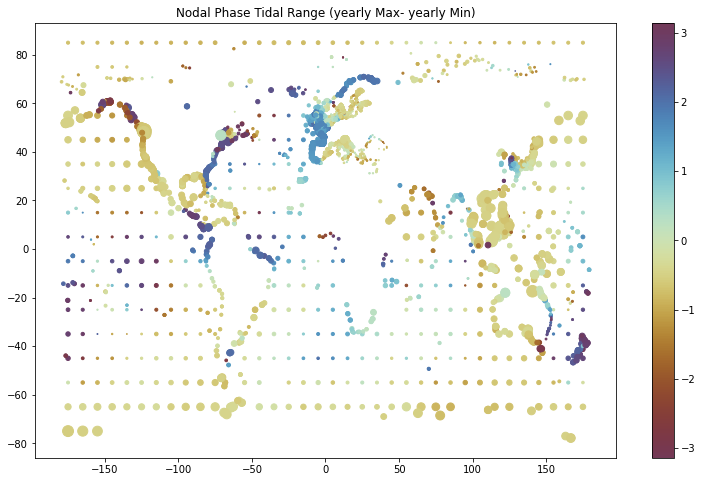

In [65]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Phase Tidal Range (yearly Max- yearly Min)')
sc = ax.scatter(lon, lat,  c=phase, cmap=romaO, vmin=-np.pi, vmax=np.pi, s=amplitude * 500)
plt.colorbar(sc, ax=ax)

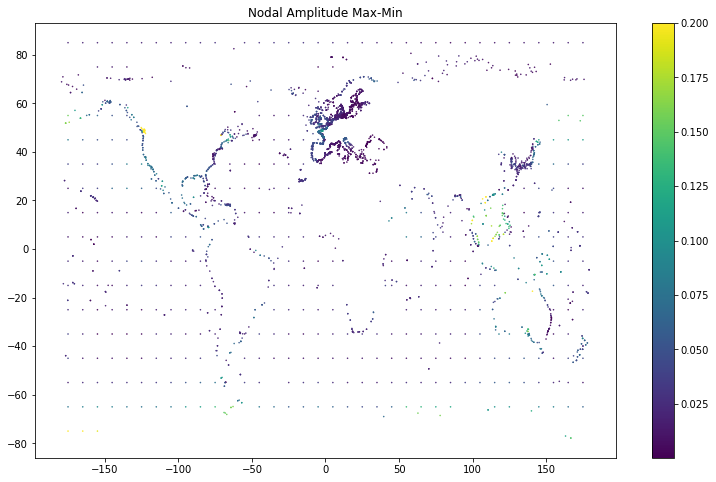

In [60]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title('Nodal Amplitude Max-Min')
im = ax.scatter(lon, lat,  c=amplitude, cmap='viridis', vmax=0.2, s=0.3, label='amplitude')
plt.colorbar(im, ax=ax)

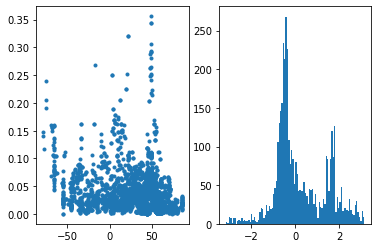

In [61]:
fig, axes = plt.subplots(ncols=2)
axes[0].plot(lat, amplitude, '.');
axes[1].hist(phase, bins=100);